In [2]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

# define paths relative to the notebook
BASE_DIR = os.path.dirname(os.getcwd())  # goes one level up from /notebooks
DATA_DIR = os.path.join(BASE_DIR, "data", "video")

WLASL_JSON = os.path.join(DATA_DIR, "WLASL_v0.3.json")
PROCESSED_DIR = os.path.join(DATA_DIR, "processed")
REBILT_JSON = os.path.join(DATA_DIR, "WLASL_rebuilt.json")

# load json
with open(WLASL_JSON, "r") as f:
    metadata = json.load(f)
MISSING_TXT = os.path.join(DATA_DIR, "missing_videos.txt")
ORIG_JSON = os.path.join(DATA_DIR, "WLASL_v0.3.json")


In [3]:
# --- load missing ids ---
with open(MISSING_TXT, "r") as f:
    missing_ids = set(line.strip() for line in f if line.strip())

print(f"Loaded {len(missing_ids)} missing video IDs")

# --- load original JSON ---
with open(ORIG_JSON, "r") as f:
    data = json.load(f)

print(f"Original entries: {len(data)} glosses")

# --- filter instances ---
rebuilt_data = []
removed_count = 0
for gloss_entry in data:
    valid_instances = []
    for inst in gloss_entry.get("instances", []):
        if inst["video_id"] not in missing_ids:
            valid_instances.append(inst)
        else:
            removed_count += 1
    if valid_instances:
        gloss_entry["instances"] = valid_instances
        rebuilt_data.append(gloss_entry)

print(f"Removed {removed_count} bad instances")
print(f"Remaining gloss entries: {len(rebuilt_data)}")

# --- save rebuilt file ---
with open(REBILT_JSON, "w") as f:
    json.dump(rebuilt_data, f, indent=2)

print(f"Rebuilt JSON saved to: {REBILT_JSON}")


Loaded 8207 missing video IDs
Original entries: 2000 glosses
Removed 8207 bad instances
Remaining gloss entries: 1999
Rebuilt JSON saved to: /home/genesis/sem1_project/sign-to-speech-with-temporal-correction/data/video/WLASL_rebuilt.json


In [4]:
from collections import Counter
import json, os

rebuilt_path = os.path.join("/home/genesis/sem1_project/sign-to-speech-with-temporal-correction/data/video", "WLASL_rebuilt.json")

with open(rebuilt_path, "r") as f:
    rebuilt = json.load(f)

split_counter = Counter()
gloss_counter = {}

for g in rebuilt:
    gloss = g["gloss"]
    count = len(g["instances"])
    gloss_counter[gloss] = count
    for inst in g["instances"]:
        split = inst.get("split", "train")
        split_counter[split] += 1

print("Per split counts:", split_counter)
print("Total valid instances:", sum(split_counter.values()))
print("Average per gloss:", sum(gloss_counter.values()) / len(gloss_counter))


Per split counts: Counter({'train': 8328, 'val': 2564, 'test': 1984})
Total valid instances: 12876
Average per gloss: 6.441220610305153


In [5]:
rebuilt = [g for g in rebuilt if any(inst.get("split") == "train" for inst in g["instances"])]
print(f"Glosses with at least one train instance: {len(rebuilt)}")


Glosses with at least one train instance: 1998


In [6]:
from collections import Counter
import json, os

json_path = "../data/video/WLASL_rebuilt.json"

with open(json_path, "r") as f:
    data = json.load(f)

split_counts = Counter()
for gloss in data:
    for inst in gloss["instances"]:
        split_counts[inst.get("split", "train")] += 1

print("Split distribution:", split_counts)


Split distribution: Counter({'train': 8328, 'val': 2564, 'test': 1984})


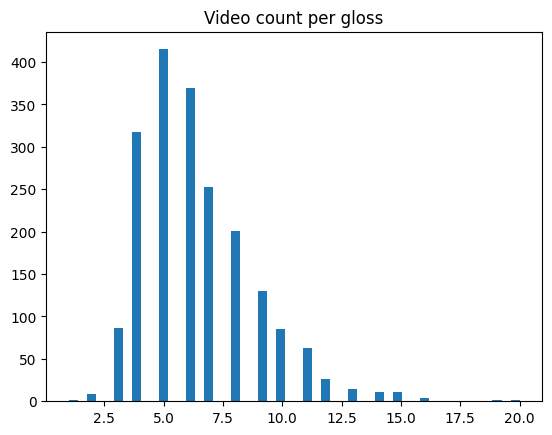

In [7]:
from collections import Counter
import matplotlib.pyplot as plt

class_counts = Counter({g["gloss"]: len(g["instances"]) for g in data})
plt.hist(list(class_counts.values()), bins=50)
plt.title("Video count per gloss")
plt.show()


In [5]:
import cv2
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def analyze_video_full(json_path, video_root, sample_size=None, plot=True):
    """
    Analyze all video stats: width, height, frame count, FPS.
    Optionally visualize all metrics together.
    """
    with open(json_path, "r") as f:
        data = json.load(f)

    all_videos = []
    for entry in data:
        for inst in entry["instances"]:
            vid_path = os.path.join(video_root, f"{inst['video_id']}.mp4")
            if os.path.exists(vid_path):
                all_videos.append(vid_path)

    if sample_size:
        all_videos = all_videos[:sample_size]

    widths, heights, frames, fps_list = [], [], [], []

    for vid in tqdm(all_videos, desc="Analyzing videos"):
        cap = cv2.VideoCapture(vid)
        if not cap.isOpened():
            continue
        widths.append(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        heights.append(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        frames.append(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps_list.append(cap.get(cv2.CAP_PROP_FPS))
        cap.release()

    widths, heights, frames, fps_list = map(np.array, (widths, heights, frames, fps_list))

    # --- Print numeric summary ---
    print(f"{'Metric':<12} | {'Min':>8} | {'Mean':>8} | {'Max':>8}")
    print("-" * 45)
    print(f"{'Width':<12} | {widths.min():8.0f} | {widths.mean():8.0f} | {widths.max():8.0f}")
    print(f"{'Height':<12} | {heights.min():8.0f} | {heights.mean():8.0f} | {heights.max():8.0f}")
    print(f"{'Frames':<12} | {frames.min():8.0f} | {frames.mean():8.0f} | {frames.max():8.0f}")
    print(f"{'FPS':<12} | {fps_list.min():8.1f} | {fps_list.mean():8.1f} | {fps_list.max():8.1f}")

    # --- Plotting ---
    if plot:
        plt.figure(figsize=(16, 8))
        plt.suptitle("WLASL Video Statistics Overview", fontsize=16, weight='bold')

        # Histograms
        plt.subplot(2, 3, 1)
        plt.hist(widths, bins=40, color='skyblue')
        plt.title("Width Distribution"); plt.xlabel("Width (px)"); plt.ylabel("Count")

        plt.subplot(2, 3, 2)
        plt.hist(heights, bins=40, color='salmon')
        plt.title("Height Distribution"); plt.xlabel("Height (px)")

        plt.subplot(2, 3, 3)
        plt.hist(frames, bins=40, color='lightgreen')
        plt.title("Frame Count Distribution"); plt.xlabel("Frame count")

        plt.subplot(2, 3, 4)
        plt.hist(fps_list, bins=40, color='orange')
        plt.title("FPS Distribution"); plt.xlabel("FPS")

        # Scatter plots
        plt.subplot(2, 3, 5)
        plt.scatter(widths, heights, s=5, alpha=0.5, color='purple')
        plt.title("Width vs Height"); plt.xlabel("Width (px)"); plt.ylabel("Height (px)")

        plt.subplot(2, 3, 6)
        plt.scatter(frames, fps_list, s=5, alpha=0.5, color='teal')
        plt.title("Frame Count vs FPS"); plt.xlabel("Frames"); plt.ylabel("FPS")

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

    return widths, heights, frames, fps_list


Analyzing videos: 100%|██████████| 12876/12876 [00:39<00:00, 329.56it/s]


Metric       |      Min |     Mean |      Max
---------------------------------------------
Width        |      426 |      426 |      426
Height       |      240 |      240 |      240
Frames       |       15 |       88 |      252
FPS          |     25.0 |     25.0 |     25.0


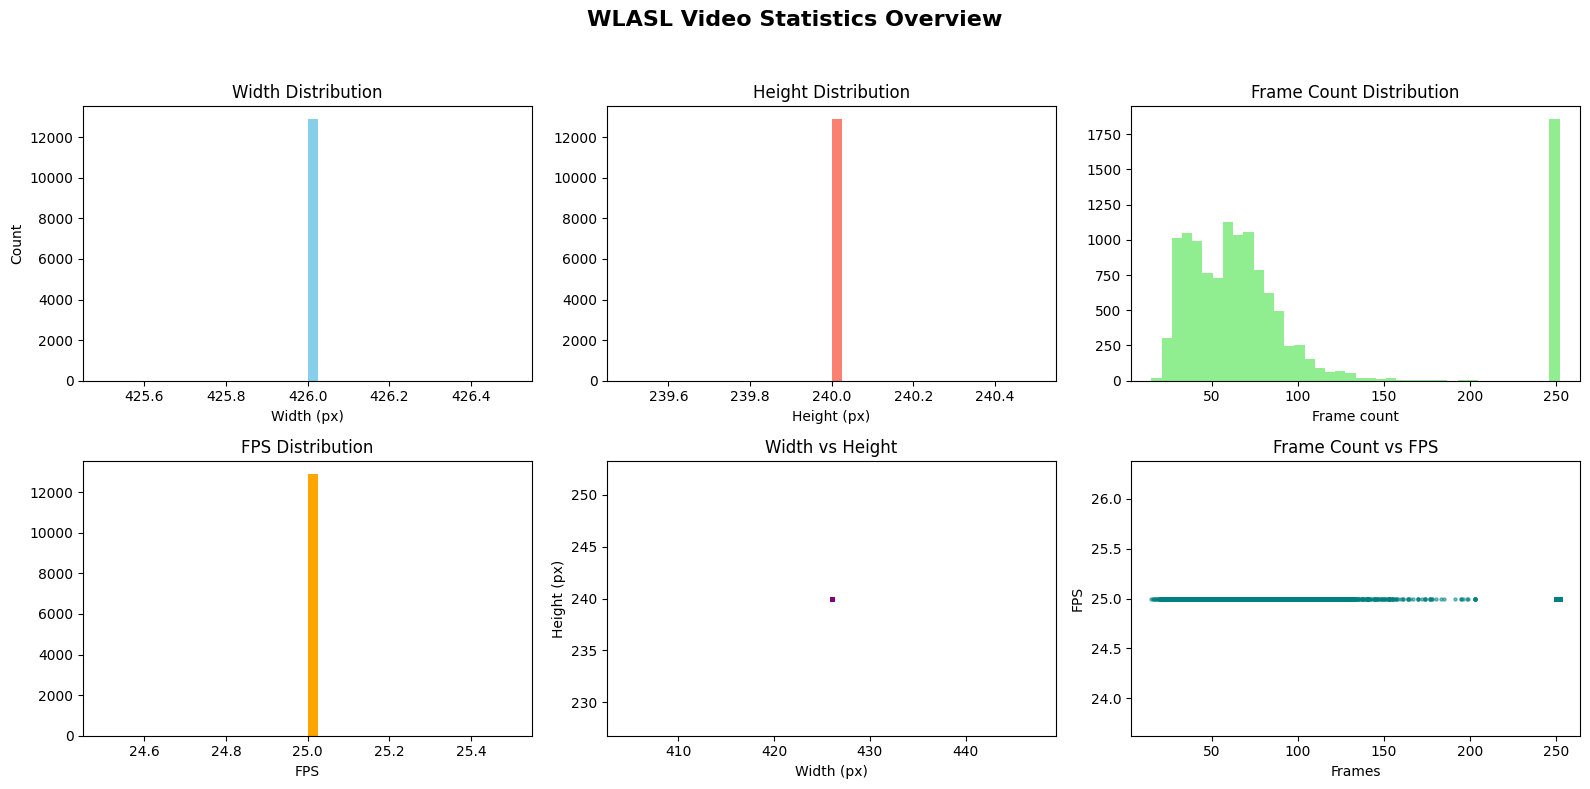

In [6]:
widths, heights, frames, fps_list = analyze_video_full(
    "../data/video/WLASL_rebuilt.json",
    "../data/video/transcoded",
    sample_size=None  # or smaller number for faster test
)


In [ ]:
from torchvision.io import read_video
frames, _, _ = read_video("../data/video/processed/63825.mp4", pts_unit="sec")
print(frames.shape)



/home/genesis/sem1_project/sign-to-speech-with-temporal-correction/env/lib/python3.12/site-packages/torchvision/io/_video_deprecation_warning.py:9: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(


torch.Size([62, 1080, 1920, 3])


In [12]:
import sys
sys.path.append("../src")


In [1]:
import sys
sys.path.append("../src")

from video_dataset_loader import WLASLDataset, pad_collate_fn
from torch.utils.data import DataLoader

ds = WLASLDataset(
    json_path="../data/video/WLASL_rebuilt.json",
    video_root="../data/video/transcoded",
    split="train"
)

sample = ds[0]
print("Sample shape:", sample["video"].shape)

from torch.utils.data import DataLoader
dl = DataLoader(ds, batch_size=4, shuffle=True, collate_fn=pad_collate_fn)
videos, labels = next(iter(dl))
print("Batch shape:", videos.shape)


[WLASL] Split=train | Videos=8328 | Classes≈1999
Sample shape: torch.Size([16, 3, 224, 224])
Batch shape: torch.Size([4, 3, 16, 224, 224])


In [3]:
from video_dataset_loader import WLASLDataset

ds = WLASLDataset(
    json_path="../data/video/WLASL_rebuilt.json",
    video_root="../data/video/transcoded",
    split="train",
    max_frames=16  # smaller sample
)

print(f"Samples: {len(ds)}")
sample = ds[0]
print(sample["video"].shape)

[WLASL] Split=train | Videos=8328 | Classes=1999
Samples: 8328
torch.Size([3, 16, 224, 224])


In [1]:
import sys, os
sys.path.append(os.path.abspath("../src"))
from video_train_model import train_model

train_model(
    json_path="../data/video/WLASL_stratified.json",
    video_root="../data/video/transcoded",
    output_dir="../models/checkpoints",
    batch_size=6,
    epochs=5,
    lr=3e-4,
    num_workers=20
)


[INFO] Using device: cuda
[INFO] Loading datasets...
[WLASL] Split=train | Videos=7998 | Classes≈1999
[WLASL] Split=val | Videos=2235 | Classes≈1999
[INFO] Found 1990 unique glosses/classes.
[INFO] Model ready with 1990 classes.
[INFO] Checkpoints will be saved in: ../models/checkpoints

🌀 Epoch [1/5] — Training...


Epoch 1/5: 100%|██████████████| 1333/1333 [10:17<00:00,  2.16it/s, Loss=7.6317, Acc=0.05%]


🔍 Evaluating on validation set...


Validation:  73%|████████████████████████████▋          | 274/373 [00:51<00:16,  5.86it/s]

[WARN] Skipping unseen label in validation set: bookshelf


Validation:  75%|█████████████████████████████▍         | 281/373 [00:52<00:15,  5.84it/s]

[WARN] Skipping unseen label in validation set: crocodile
[WARN] Skipping unseen label in validation set: consume


Validation:  77%|█████████████████████████████▉         | 286/373 [00:53<00:15,  5.79it/s]

[WARN] Skipping unseen label in validation set: dice


Validation:  79%|██████████████████████████████▊        | 295/373 [00:54<00:13,  5.78it/s]

[WARN] Skipping unseen label in validation set: hang up


Validation:  80%|███████████████████████████████▏       | 298/373 [00:55<00:12,  5.77it/s]

[WARN] Skipping unseen label in validation set: iron


Validation:  83%|████████████████████████████████▍      | 310/373 [00:57<00:10,  5.77it/s]

[WARN] Skipping unseen label in validation set: penny


Validation:  87%|█████████████████████████████████▊     | 323/373 [00:59<00:08,  5.88it/s]

[WARN] Skipping unseen label in validation set: smoking


Validation: 100%|███████████████████████████████████████| 373/373 [01:07<00:00,  5.49it/s]


✅ Epoch 1: Train Acc=0.05% | Val Acc=0.04% | Time=617.0s | Saved=mvit_acc_0.05_20251016_174309.pth

🌀 Epoch [2/5] — Training...


Epoch 2/5:  18%|██▋            | 241/1333 [01:55<08:45,  2.08it/s, Loss=7.5602, Acc=0.00%]


KeyboardInterrupt: 